# Testing notebook: Lung & heart sound separation

**Advertencia**: La siguiente celda debe ser ejecutada **SOLO UNA VEZ** durante la sesión.

In [1]:
import os
import sys

# Definición de la carpeta actual
current = os.getcwd()
# Obtener la carpeta parent
parent = os.path.dirname(current)
# Agregando a las carpetas a revisar
os.chdir(parent)

**Test de sanidad**: Asegurarse de que la carpeta sea la correcta.

In [3]:
assert os.getcwd().split('\\')[-1] == 'Lung_heart_source_separation'

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from prediction_functions import find_and_open_audio, hss_segmentation
from hsp_utils.filter_and_sampling import downsampling_signal

# Definición de los parámetros de filtros pasa bajos de la salida de la red
lowpass_params = {'freq_pass': 140, 'freq_stop': 150}

# Definición de los parámetros NMF
nmf_parameters = {'n_components': 2, 'N': 1024, 'N_lax': 100, 
                  'N_fade': 100, 'noverlap': int(0.9 * 1024), 'repeat': 0, 
                  'padding': 0, 'window': 'hamming', 'init': 'random',
                  'solver': 'mu', 'beta': 2, 'tol': 1e-4, 
                  'max_iter': 500, 'alpha_nmf': 0, 'l1_ratio': 0, 
                  'random_state': 0, 'dec_criteria': 'temp_criterion'}

# Otros parámetros
model_name = 'definitive_segnet_based'
db_folder = 'samples_test'

# Segmentación de sonidos cardiorrespiratorios

En primer lugar se selecciona un archivo disponible en la carpeta `samples_test` utilizando la función `find_and_open_audio`. Se buscará obtener también sus etiquetas reales de posición de sonido cardiaco.

In [5]:
# Cargando el archivo de audio 
(audio, samplerate), labels = find_and_open_audio(db_folder=db_folder, true_value=True)
audio = audio / max(abs(audio))

Seleccione el archivo que desea descomponer:
[1] 015_Patient006_Dis0.wav
[2] 041_Patient010_Dis0.wav
[3] 056_Patient013_Dis0.wav
[4] 080_Patient018_Dis0.wav
[5] 143_Patient030_Dis1.wav
[6] 151_Patient031_Dis0.wav
[7] 197_Patient041_Dis1.wav
[8] 248_Patient053_Dis0.wav
[9] 267_Patient057_Dis1.wav
[10] 347_Patient067_Dis0.wav
[11] 364_Patient070_Dis0.wav
[12] 416_Patient078_Dis0.wav
[13] 435_Patient081_Dis1.wav
[14] 483_Patient085_Dis1.wav
[15] 500_Patient087_Dis1.wav
[16] 571_Patient101_Dis1.wav
[17] 626_Patient109_Dis1.wav
[18] 701_Patient118_Dis1.wav
[19] 719_Patient120_Dis1.wav
[20] 763_Patient127_Dis0.wav
Selección: 13


Se aplica el algoritmo de segmentación utilizando la función `hss_segmentation` del módulo `prediction_functions.py`.

In [20]:
# Obteniendo la salida de la red
_, y_hat_to, (y_out2, y_out3, y_out4) = \
        hss_segmentation(audio, samplerate, model_name,
                         length_desired=len(audio),
                         lowpass_params=lowpass_params,
                         plot_outputs=False)

Samplerate adecuado a fs = 1000 Hz.
Señal acondicionada a 1000 Hz para la segmentación.
1/1 [==============================] - 0s 2ms/step


# Gráficos

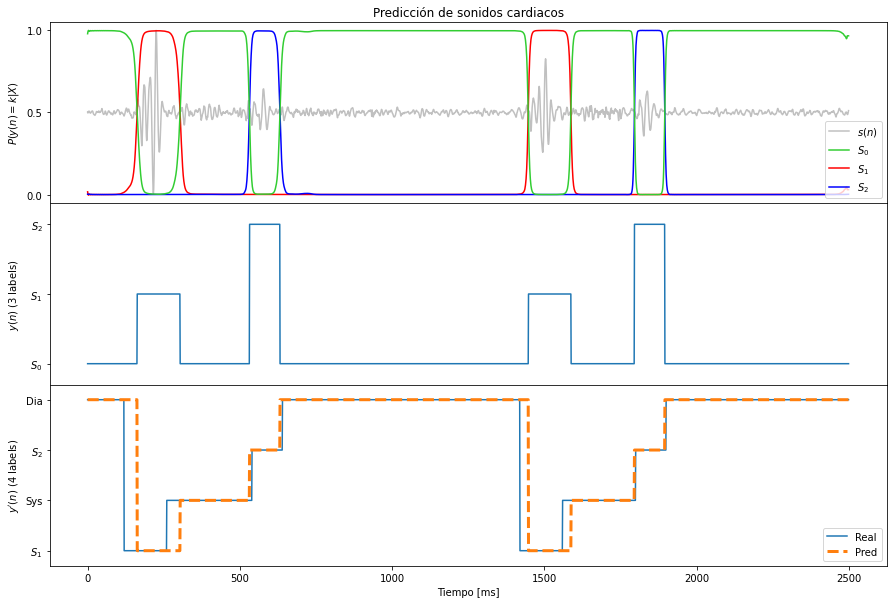

In [36]:
# Creación de la figura
fig, axs = plt.subplots(3, 1, figsize=(15,10), sharex=True, frameon=True)

audio_data_plot = 0.5 * audio / max(abs(audio))
axs[0].plot(audio_data_plot + 0.5, label=r'$s(n)$', color='silver', zorder=0)
axs[0].plot(y_hat_to[0,:,0], label=r'$S_0$', color='limegreen', zorder=2)
axs[0].plot(y_hat_to[0,:,1], label=r'$S_1$', color='red', zorder=1)
axs[0].plot(y_hat_to[0,:,2], label= r'$S_2$', color='blue', zorder=1)
axs[0].legend(loc='lower right')
axs[0].set_title('Predicción de sonidos cardiacos')
axs[0].set_yticks([0, 0.5, 1])
axs[0].set_ylabel(r'$P(y(n) = k | X)$')

axs[1].plot(y_out3)
axs[1].set_ylabel(r'$y(n)$ (3 labels)')
axs[1].set_yticks([0,1,2])
axs[1].set_yticklabels([r'$S_0$', r'$S_1$', r'$S_2$'])
axs[1].set_ylim([-0.3, 2.3])

axs[2].plot(np.repeat(labels, 20), label='Real', color='C0')
axs[2].plot(y_out4, label='Pred', color='C1', linestyle='--', linewidth=3)
axs[2].set_xlabel('Tiempo [ms]')
axs[2].set_yticks([1,2,3,4])
axs[2].set_yticklabels([r'$S_1$', 'Sys', r'$S_2$', 'Dia'])
axs[2].set_ylabel(r"$y'(n)$ (4 labels)")
axs[2].set_ylim([0.7, 4.3])
axs[2].legend(loc='lower right')

fig.align_ylabels(axs[:])

# Remover espacio horizontal entre plots
fig.subplots_adjust(wspace=0.1, hspace=0)

plt.show()